Example notebook for SIFT based image registration.  

In [1]:
from skimage import io
from skimage.color import rgb2gray

from skimage.feature import match_descriptors, plot_matches, SIFT
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'

In [2]:
src_path = 'src_img.tif'
des_path = 'des_img.png'

In [3]:
# read images and convert to gray-scale
src = rgb2gray(io.imread(src_path))
des = rgb2gray(io.imread(des_path))

src.shape, des.shape

((543, 600), (543, 600))

### SIFT Based Keypoint Matching

In [4]:
def get_keypoints_and_descriptors(detector, img):
    detector.detect_and_extract(img)
    kps = detector.keypoints
    desc = detector.descriptors
    
    return kps, desc

In [5]:
def get_matches(desc_src, desc_des, max_ratio):
    matches = match_descriptors(desc_src, desc_des, max_ratio=max_ratio, cross_check=True)
    
    if matches.shape[0]<4:
        print('Not enough matched keypoints were detected')
        return None
    else:
        return matches

In [6]:
# Define keypoint descriptor method:
detector = SIFT()
# Define max ratio of compared descriptor matching:
max_ratio=0.6

In [7]:
%%time
kps_src, desc_src = get_keypoints_and_descriptors(detector, src)
kps_des, desc_des = get_keypoints_and_descriptors(detector, des)

CPU times: user 796 ms, sys: 84.8 ms, total: 881 ms
Wall time: 880 ms


In [8]:
matches = get_matches(desc_src, desc_des, max_ratio)

In [9]:
m_src = kps_src[matches[:,0]]
m_des = kps_des[matches[:,1]]

In [10]:
### we sometimes have some keypoints duplicates
m_src, idx = np.unique(m_src, axis=0, return_index=True)
m_des = m_des[idx,:]
matches = matches[idx,:]

Text(0.5, 1.0, 'Matches')

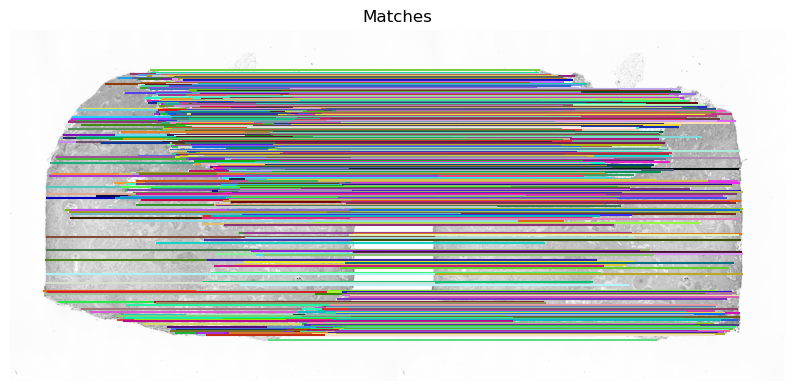

In [11]:
# Show matches
fig, ax = plt.subplots(figsize=(10, 6))
plot_matches(ax, src, des, kps_src, kps_des, matches, only_matches=True)
ax.axis('off')
ax.set_title("Matches")

In [12]:
n_kps = matches.shape[0]
print(f'Number of matches: {n_kps}')

Number of matches: 657


Text(0.5, 1.0, 'destination image matched keypoints')

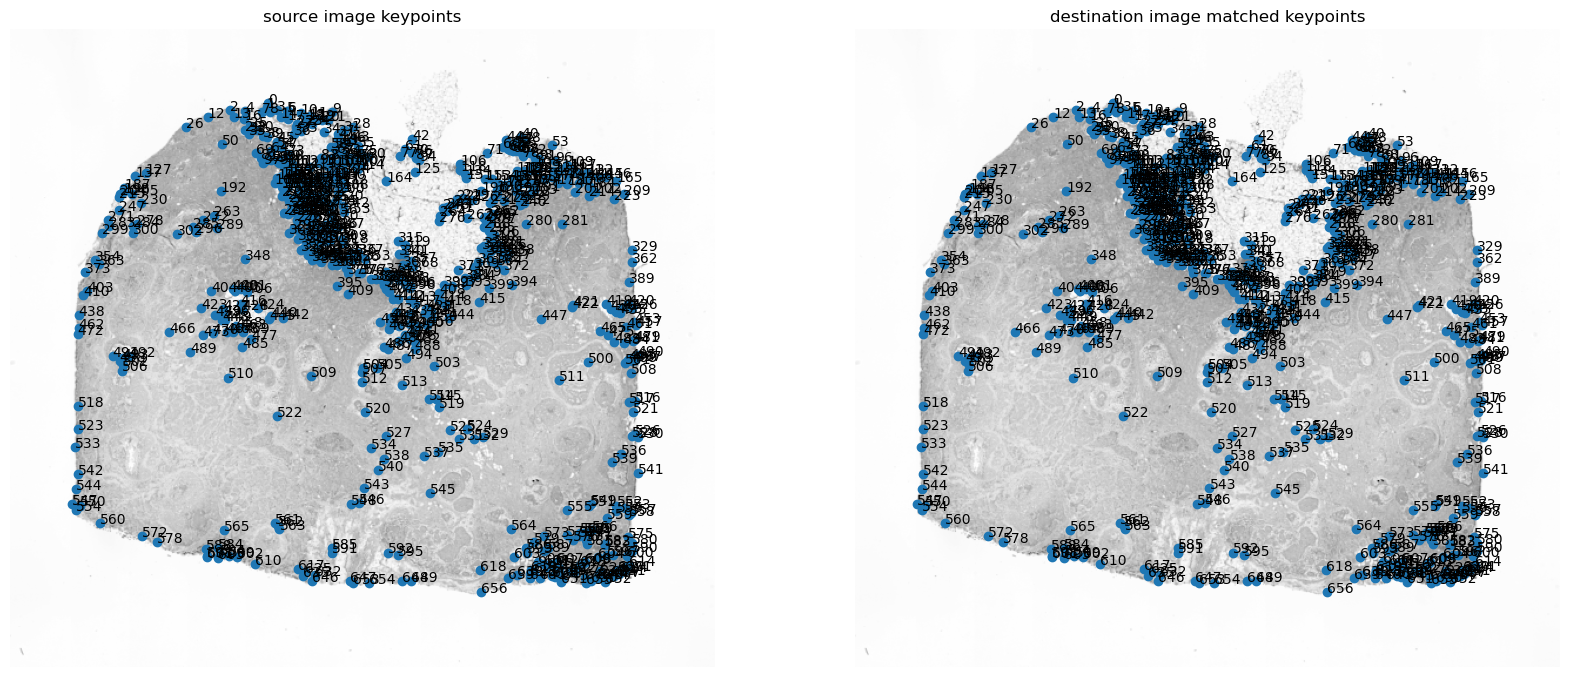

In [13]:
# Plot keypoints idxs 
fig,ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(src)
ax[0].scatter(m_src[:,1], m_src[:,0])
for i in range(n_kps):
    ax[0].annotate(i, (m_src[i,1], m_src[i,0]))
ax[0].axis('off')
ax[0].set_title('source image keypoints')
    
ax[1].imshow(des)
ax[1].scatter(m_des[:,1], m_des[:,0])
for i in range(n_kps):
    ax[1].annotate(i, (m_des[i,1], m_des[i,0]))
ax[1].axis('off')
ax[1].set_title('destination image matched keypoints')

### Find Registration Matrix
https://vivekseth.com/computer-vision-matrix-differences/

In [14]:
m_src_f = np.flip(m_src, axis=1).astype(np.float32)
m_des_f = np.flip(m_des, axis=1).astype(np.float32)

In [15]:
warp_mat = cv2.findHomography(m_src_f, m_des_f)[0]

In [16]:
# Apply transformation
warp_src = cv2.warpPerspective(src, warp_mat, (src.shape[1], src.shape[0]))#, flags=cv2.INTER_LINEAR)

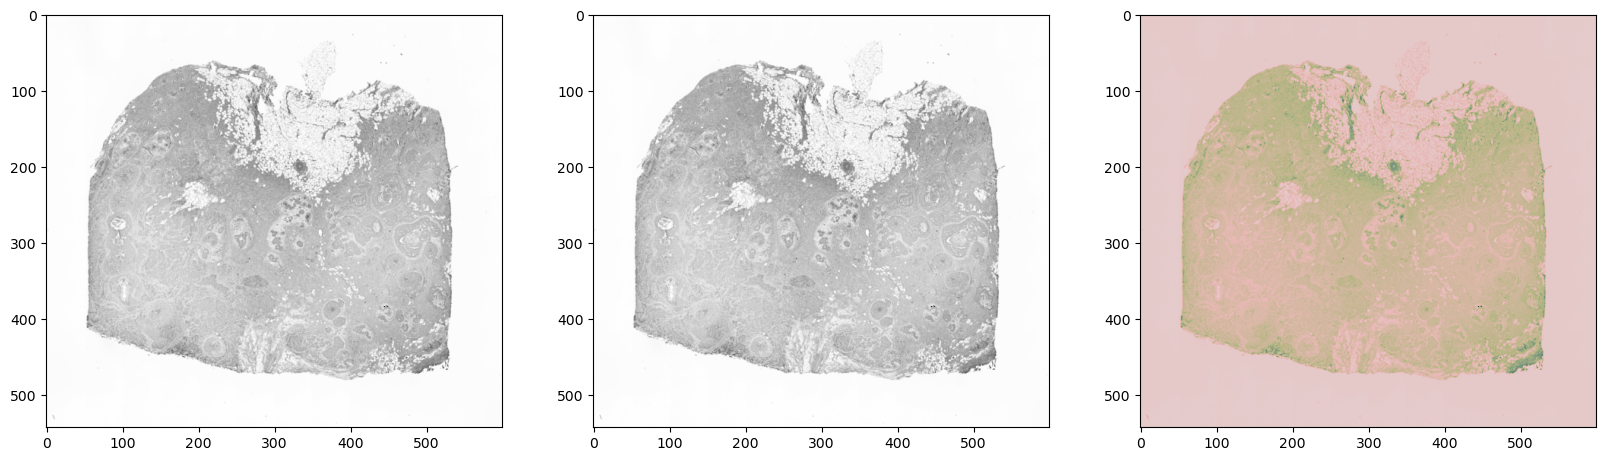

In [17]:
## Plot results:
fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(des)
ax[1].imshow(warp_src)
ax[2].imshow(des)
ax[2].imshow(warp_src, alpha=0.2, cmap='jet')

In [18]:
## test results - get mean euclidean distance (the error) of all matched keypoints:
# Lower is better

def check_euc_distance(kps1, kps2):

    kps1_1 = np.append(kps1, np.ones((n_kps,1)), axis=1)

    w_kps1 =  np.dot(warp_mat, kps1_1.T).T
    w_kps1 = (w_kps1.T/w_kps1[:,2]).T[:,:2]

    dist = np.linalg.norm(w_kps1 - kps2, axis=1)

    mean_distance = np.mean(dist)
    
    print(f'mean distance between keypoint in destination to keypoint in registered space:{mean_distance} for {n_kps} keypoints used.')
        

In [19]:
check_euc_distance(m_src_f, m_des_f)

mean distance between keypoint in destination to keypoint in registered space:2.0742203847083582e-13 for 657 keypoints used.
